In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

# Metrics
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, roc_curve, silhouette_score
from sklearn.metrics import plot_confusion_matrix

# Classifiers
from sklearn.dummy import DummyClassifier
from sklearn.tree  import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [4]:
#To create a dataframe using a subset of features from original dataset
def create_custom_dataframe(df, features, label_column):
    columns = features + [label_column]
    return df[columns].copy()

def split_dataset(X, y, test_size=None, stratify=False):
    if stratify:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=True, stratify=y)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=True)
    return (X_train, X_test, y_train, y_test)


def display_cross_validation_results(model, X_train, y_train, folds):
    results = cross_val_score(model, X_train, y_train, cv=folds, scoring='accuracy')
    print(f"Cross validation results with {folds} folds: {results}")
    

def build_classifiers():
    return [
        ("RandomForestClassifier", RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=27)),
        ("ExtraTreesClassifier", ExtraTreesClassifier(n_estimators=100, random_state=27)),
        ("KNNClassifier", KNeighborsClassifier()),
        ("DecisionTreeClassifier", DecisionTreeClassifier()),
        ("SVC", SVC(kernel='linear', probability=True))
    ]

#this function used to build and evalute different models 
def run_classifiers(X_train, X_test, y_train, y_test):
    classifiers = build_classifiers()

    for key, model in classifiers:
        model.fit(X_train, y_train)
        y_predict = model.predict(X_test)
        
    print("Individual Classifiers Score Results")
    print("-----------------------------------")
    for key, model in classifiers:
        print(f"{key}: Training Accuracy: {model.score(X_train, y_train)} | Test Accuracy: {model.score(X_test, y_test)}")
    
    print("")  
    

In [5]:
pd.set_option('display.max_rows', None)

When I started working on my models, I noticed an error that seemed to relate to checking the integrity of the data and the error said I had strings. I couldn't find it in the head or isna at first, so I opened the spreadsheet and saw there were items that were ?'s. isna does not seem to be interpreted as NaN, and was not showing up as such. I added the na_values = '?' to include them as NaN.

In [6]:
df = pd.read_csv("breastcancer2.csv", na_values = '?')
df.head()

,sample#,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
0,1000025,5,1,1,1,2,1.0,3,1,1,2
1,1002945,5,4,4,5,7,10.0,3,2,1,2
2,1015425,3,1,1,1,2,2.0,3,1,1,2
3,1016277,6,8,8,1,3,4.0,3,7,1,2
4,1017023,4,1,1,3,2,1.0,3,1,1,2


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   sample#                      699 non-null    int64  
 1   Clump Thickness              699 non-null    int64  
 2   Uniformity of Cell Size      699 non-null    int64  
 3   Uniformity of Cell Shape     699 non-null    int64  
 4   Marginal Adhesion            699 non-null    int64  
 5   Single Epithelial Cell Size  699 non-null    int64  
 6   Bare Nuclei                  683 non-null    float64
 7   Bland Chromatin              699 non-null    int64  
 8   Normal Nucleoli              699 non-null    int64  
 9   Mitoses                      699 non-null    int64  
 10  Class                        699 non-null    int64  
dtypes: float64(1), int64(10)
memory usage: 60.2 KB


<AxesSubplot:>

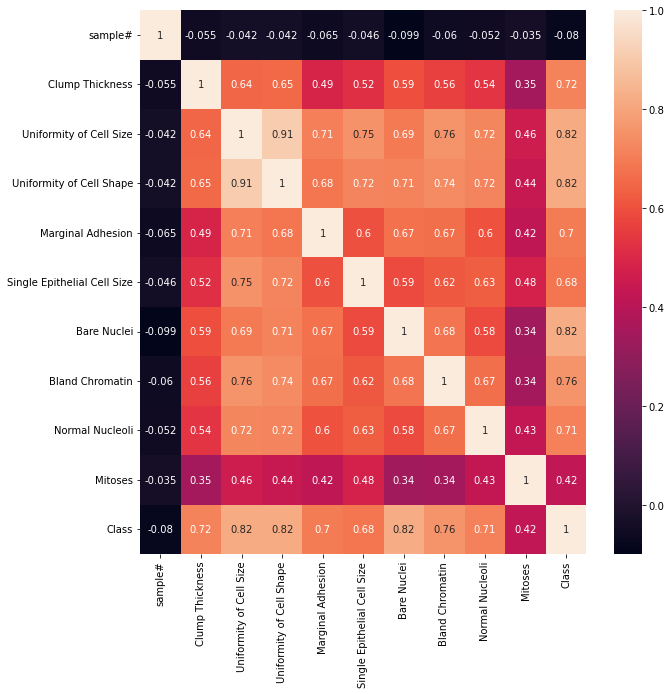

In [8]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)

Description of the problem:

Based on attributes of a sample taken of a tumor can we tell, using machine learning, if the tumor is benign or malignant?

Description of the dataset:

There are 699 rows and 11 features

   #  Attribute                     Domain
   -- -----------------------------------------
   1. Sample code number            id number
   2. Clump Thickness               1 - 10
   3. Uniformity of Cell Size       1 - 10
   4. Uniformity of Cell Shape      1 - 10
   5. Marginal Adhesion             1 - 10
   6. Single Epithelial Cell Size   1 - 10
   7. Bare Nuclei                   1 - 10
   8. Bland Chromatin               1 - 10
   9. Normal Nucleoli               1 - 10
  10. Mitoses                       1 - 10
  11. Class:                        (2 for benign, 4 for malignant)
  
  I read more about these features at: https://www.mdpi.com/2075-4418/10/3/136/htm and https://rstudio-pubs-static.s3.amazonaws.com/491489_b86f191488ab4ed0a37e7a95c839a8f4.html
  
  #### Features Description:

In each of these features 
- Sample code number: id number for each sample

- Clump Thickness : grouping of cells in a multilayer, benign cells tend to be grouped in mono-layers, while cancerous cells are often grouped in multi-layer

- Uniformity of Cell Size: how uniform the cell sizes are i.e. all of the same size or a wide variety - this can indicate grouping of cancer cells in multilayer (cancer cells tend to vary in size)

- Uniformity of Cell Shape: how uniform the cell shapes are i.e. all of the same shape or a wide variety (cancer cells tend to vary in shape)

- Marginal Adhesion: adhesion level -normal cells tend to stick together, cancer cells tend to lose this ability. Loss of adhesion appears to be a sign of malignancy.

- Single Epithelial Cell Size: relates to uniformity, if this size becomes large it may be a malignant cell

- Bare Nuclei: without cytoplasm coating, found in benign tumors

- Bland Chromatin: describes a uniform texture of the nucleus seen in the benign cell. In cancer cells the chromatin tends to be coarser

- Normal Nucleoli: Nucleoli are small structures seen in the nucleus. Generally very small in benign cells, in cancer cells they become more prominent and sometimes there are more of them

- Mitoses: process in cell division by which the nucleus divides, this is an estimate of the number of mitosis that has taken place. The larger the value the greater the chance of malignancy.

- Class: this will end up as our label, 2 for benign i.e. not harmful, malignant i.e. harmful

Supervised or unsupervised:

This will be supervised as we have the labels, but we could take the labels off and see what happens in unsupervised to check.

Regression or classification:

Classification as we will be looking to diagnose/classify based on the data and we are predicting discrete labels as opposed to continuous data.


In [9]:
df.shape

(699, 11)

In [10]:
#Find out missing values for each column
df.isna().sum()

sample#                         0
Clump Thickness                 0
Uniformity of Cell Size         0
Uniformity of Cell Shape        0
Marginal Adhesion               0
Single Epithelial Cell Size     0
Bare Nuclei                    16
Bland Chromatin                 0
Normal Nucleoli                 0
Mitoses                         0
Class                           0
dtype: int64

I believe as this only represents 16 items it will be more efficient to drop the values as opposed to filling with the mean/mediam/etc.

In [11]:
#Removing Null values
data=df.dropna()

In [12]:
#Find out missing values for each column
data.isna().sum()

sample#                        0
Clump Thickness                0
Uniformity of Cell Size        0
Uniformity of Cell Shape       0
Marginal Adhesion              0
Single Epithelial Cell Size    0
Bare Nuclei                    0
Bland Chromatin                0
Normal Nucleoli                0
Mitoses                        0
Class                          0
dtype: int64

In [13]:
data['Class'].value_counts()

2    444
4    239
Name: Class, dtype: int64

In [14]:
data.describe()

,sample#,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
count,6.830000e+02,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000
mean,1.076720e+06,4.442167,3.150805,3.215227,2.830161,3.234261,3.544656,3.445095,2.869693,1.603221,2.699854
std,6.206440e+05,2.820761,3.065145,2.988581,2.864562,2.223085,3.643857,2.449697,3.052666,1.732674,0.954592
min,6.337500e+04,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000
25%,8.776170e+05,2.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000,1.000000,1.000000,2.000000
50%,1.171795e+06,4.000000,1.000000,1.000000,1.000000,2.000000,1.000000,3.000000,1.000000,1.000000,2.000000
75%,1.238705e+06,6.000000,5.000000,5.000000,4.000000,4.000000,6.000000,5.000000,4.000000,1.000000,4.000000
max,1.345435e+07,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,4.000000


The data seems very clean (no na values) and the describe shows us what we would expect - as the features are only values 1-10, they are relatively tight together. I do not believe it will help us to do work on outliers at this point in time, as the data does not seem to have a wide range. If I begin to do work on the data and see potential errors or things that may not make sense, I will re-evaluate this decision.

<AxesSubplot:ylabel='Frequency'>

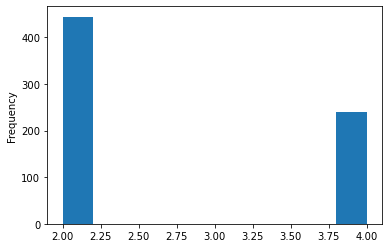

In [15]:
data["Class"].plot(kind = 'hist')

It looks like our intended label has many more cases of 4 compared to 2, where 4 represents malignant and 2 represents benign.

I am curious what the plots may look like for some of the highest correlated features when compared to our eventual label, from the heatmap some of the highest correlated features seem to be: uniformity of cell size at .82, uniformity of cell shape at .82, and clump thickness at .72


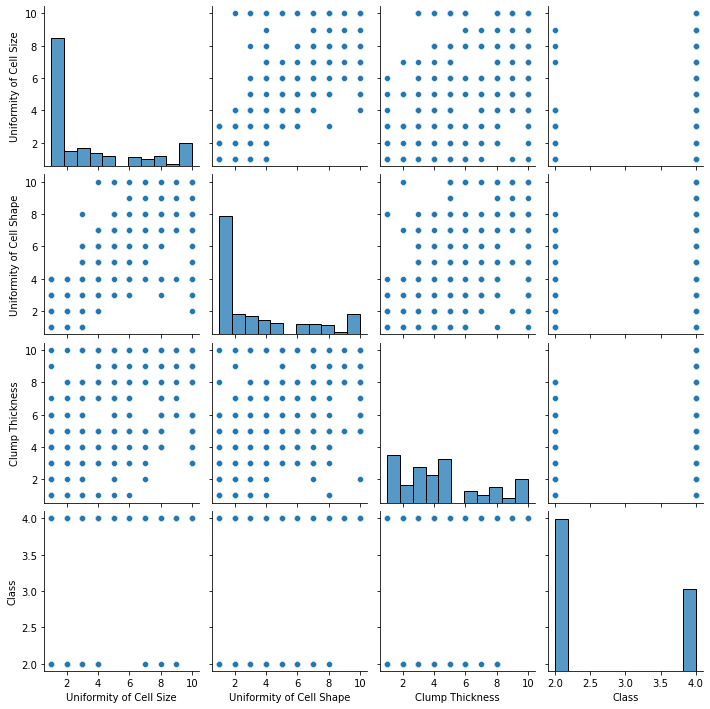

In [16]:
# Using Seaborn
sns.pairplot(data[['Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Clump Thickness', 'Class']]) # Taking Subset
plt.show()

Hm from this it seems there might be a correlation, but it may not be as cut and dry as we were hoping (i.e. there are values of 4's or malignant for every value of each of these highly correlated features, though it is interesting that there are no 2's or benign labels with any of these features at a 10.

When making the features and labels subsets I will leave out the sample number as this does not seem like it will be relevant to our process

In [17]:
label = 'Class'
features = ['Clump Thickness', 'Uniformity of Cell Size', 'Uniformity of Cell Shape', 'Marginal Adhesion', 
            'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin', 'Normal Nucleoli', 'Mitoses']


Separating dataframe winto features (X) and labels (y)

In [18]:
X=data[features].copy()
y=data[label].copy()

In [19]:
print("Features and labels Shape")
print("-----------------")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

Features and labels Shape
-----------------
X shape: (683, 9)
y shape: (683,)


In [20]:
print("FEATURES")
X.head()

FEATURES


,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
0,5,1,1,1,2,1.0,3,1,1
1,5,4,4,5,7,10.0,3,2,1
2,3,1,1,1,2,2.0,3,1,1
3,6,8,8,1,3,4.0,3,7,1
4,4,1,1,3,2,1.0,3,1,1


In [21]:
print("LABELS")
y.head()

LABELS


0    2
1    2
2    2
3    2
4    2
Name: Class, dtype: int64

We split the features and label up so we can start to work on them a bit more. Here we are going to split them into a training and test set, and start looking at supvervised algorithms and what kind of accuracy they present individually.

We will split the data into 80% train and 20% test

In [22]:
X_train, X_test, y_train, y_test = split_dataset(X, y, test_size=0.2)
   
print("Dataset Split Shapes")
print("-----------------")
print(f"X_train shape: {X_train.shape}")
print(f"y_train_val shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")
print("")


Dataset Split Shapes
-----------------
X_train shape: (546, 9)
y_train_val shape: (546,)
X_test shape: (137, 9)
y_test shape: (137,)



In [23]:
# Train model
model = DummyClassifier(strategy="most_frequent") # setup algorithm model
model.fit(X_train, y_train)

# print performance measure
print(f"-----------------------------------------")
display_cross_validation_results(model, X_train, y_train, 3)
print(f"Training set accuracy: {model.score(X_train, y_train)}, Test set accuracy: {model.score(X_test, y_test)}")



-----------------------------------------
Cross validation results with 3 folds: [0.67032967 0.67032967 0.66483516]
Training set accuracy: 0.6684981684981685, Test set accuracy: 0.5766423357664233


In [24]:
run_classifiers(X_train, X_test, y_train, y_test)

Individual Classifiers Score Results
-----------------------------------
RandomForestClassifier: Training Accuracy: 0.9908424908424909 | Test Accuracy: 0.9562043795620438
ExtraTreesClassifier: Training Accuracy: 1.0 | Test Accuracy: 0.9635036496350365
KNNClassifier: Training Accuracy: 0.9743589743589743 | Test Accuracy: 0.948905109489051
DecisionTreeClassifier: Training Accuracy: 1.0 | Test Accuracy: 0.9343065693430657
SVC: Training Accuracy: 0.9743589743589743 | Test Accuracy: 0.9635036496350365



The test accuracies here seem pretty good!

The top individual performer seems to be a tie between extratrees and SVC. 

ExtraTrees generally works many decision trees, then samples each decision tree. The split value is randomly selected, and the trees are very diverse. For a question such as can we tell if a sample is benign or malignant based on the features it has, a decision tree does intuitively seem to make sense. There seem to be a number of characteristics that differentiate a benign and malignant cell/sample, so if we use decision trees to say is the size abnormal? How is it grouped? Has more than normal mitosis taken place? We can answer these questions, and if enough of them are yes it would make sense this would eventually lead to the classification of benign of malignant.

SVC works to separate / classify based on linear classifiers. This will help to separate out the classes. Given our classification between benign and malignant as the goal, and as the features seem to have a high correlation it makes sense SVC works very well as a classifier on this data.

RandomForest, KNN, and DecisionTree by no means did poorly (the lowest was .934). 
RandomForest is not far behind ExtraTrees, which would make sense as RandomForest trains many decision trees based on random subsets of the features, and averages out their predictions - but randomforest tries to choose the optimum split while extratrees chooses randomly. Plus Randomforest uses bootstrapping while ExtraTrees does not. Bootstrapping involves sampling subsets with replacements and could select a data point more than once for a resampled dataset. There may have been some random decisions where the extratrees came out on top or perhaps the data lends itself more to extratrees without the bootstrapping.

KNN - Here we are using a technique of k nearest neighbors in a supervised learning model. This algorithm works to find clusters of data that are located nearest a number of clusters. By separating these clusters and finding each datapoint's "nearest neighbor" to classify each datapoint, the algorithm can help to identify how this data should be classified.

Now let's try to use some soft/hard voting and see if we can improve on the individual performer results.

In [25]:
def build_ensemble_classifiers():
    return [
        ("RandomForestClassifier", RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=27)),
        ("ExtraTreesClassifier", ExtraTreesClassifier(n_estimators=100, random_state=27)),
        ("KNNClassifier", KNeighborsClassifier()),
        ("DecisionTreeClassifier", DecisionTreeClassifier()),
        ("SVC", SVC(kernel='linear', probability=True))
    ]

In [26]:
def run_ensemble_classifier(X_train, X_test, y_train, y_test, include_soft):
    
    classifiers = build_ensemble_classifiers()

    voting_clf = VotingClassifier(classifiers)
    voting_clf.fit(X_train, y_train)
    y_predict = voting_clf.predict(X_test)
    
    print("Ensemble Classifier Score Results")
    print("---------------------------------")
    
    if include_soft:
        voting_clf.voting = "soft"
        print(f"Soft VotingClassifier: {voting_clf.score(X_test, y_test)}") 

    voting_clf.voting = "hard"
    print(f"Hard VotingClassifier: {voting_clf.score(X_test, y_test)}") 
    
    print("")    
    
    return voting_clf
 

In [27]:
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier, BaggingClassifier

In [28]:
run_ensemble_classifier(X_train, X_test, y_train, y_test, True)

Ensemble Classifier Score Results
---------------------------------
Soft VotingClassifier: 0.9781021897810219
Hard VotingClassifier: 0.9635036496350365



VotingClassifier(estimators=[('RandomForestClassifier',
                              RandomForestClassifier(max_leaf_nodes=16,
                                                     n_estimators=500,
                                                     n_jobs=-1,
                                                     random_state=27)),
                             ('ExtraTreesClassifier',
                              ExtraTreesClassifier(random_state=27)),
                             ('KNNClassifier', KNeighborsClassifier()),
                             ('DecisionTreeClassifier',
                              DecisionTreeClassifier()),
                             ('SVC', SVC(kernel='linear', probability=True))])

It seems the soft voting .9781 beats our top individual performer above (ExtraTrees or SVC's .9635). Let's see if we can take out the two weakest performers to improve our results (KNN and DecisionTree). (Hard voting picks the prediction with the highest number of votes compared to soft voting which combines probabilities of each prediction in each model and picks the prediction wtih the highest total probability. 

In [29]:
def build_ensemble_classifiers():
    return [
        ("RandomForestClassifier", RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=27)),
        ("ExtraTreesClassifier", ExtraTreesClassifier(n_estimators=100, random_state=27)),
        ("SVC", SVC(kernel='linear', probability=True))
    ]

In [30]:
run_ensemble_classifier(X_train, X_test, y_train, y_test, True)

Ensemble Classifier Score Results
---------------------------------
Soft VotingClassifier: 0.9635036496350365
Hard VotingClassifier: 0.9635036496350365



VotingClassifier(estimators=[('RandomForestClassifier',
                              RandomForestClassifier(max_leaf_nodes=16,
                                                     n_estimators=500,
                                                     n_jobs=-1,
                                                     random_state=27)),
                             ('ExtraTreesClassifier',
                              ExtraTreesClassifier(random_state=27)),
                             ('SVC', SVC(kernel='linear', probability=True))])

It does not seem so! Perhaps some of the probabilities/votes presented from these two "weaker" models actually are helping the predictions and are useful in combining to improve the overall performance. Hard voting is usually done by aggregating the predictions of each classifier, and then predicting the class that gets the most votes i.e. a majority voting type of classifier. Soft voting combines the probabilities of each prediction and picks the prediction with the highest total probability. 

Drawing conclusions from our earlier voting models, it seems soft voting with a .9781 is our best potential model and with this high of an accuracy it does seem we are able to determine, based on attributes of a sample taken of a tumor, if the tumor is benign or malignant.

Attempting unsupervised learning now. Making df_copy with just the features i.e. no label. 

In [31]:
df_copy = data[features].copy()

df_copy.head()


,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses
0,5,1,1,1,2,1.0,3,1,1
1,5,4,4,5,7,10.0,3,2,1
2,3,1,1,1,2,2.0,3,1,1
3,6,8,8,1,3,4.0,3,7,1
4,4,1,1,3,2,1.0,3,1,1


In [32]:
df_copy.shape

(683, 9)

determining the variance of features

In [33]:
pca = PCA().fit(df_copy)

pca.explained_variance_ratio_

array([0.69050756, 0.07195066, 0.06055921, 0.04442012, 0.03900513,
       0.03443899, 0.02529478, 0.02246508, 0.01135845])

expressed as a cumulative sum

In [34]:
cumsum = np.cumsum(pca.explained_variance_ratio_)
cumsum

array([0.69050756, 0.76245823, 0.82301744, 0.86743756, 0.9064427 ,
       0.94088169, 0.96617646, 0.98864155, 1.        ])

we can also utilize visualization

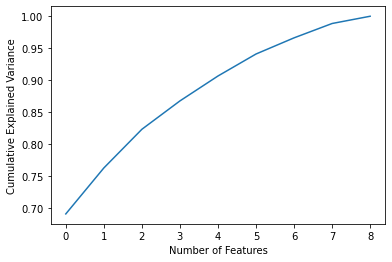

In [35]:
plt.plot(cumsum)
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Explained Variance');

although more features may be useful, bringing this down to 2 dimensions will help to better visualize the relationships.

In [36]:
pca = PCA(n_components=2).fit(df_copy)
pca_2d = pca.transform(df_copy)
df_2d = pd.DataFrame(pca_2d)

df_2d.head(10)

,0,1
0,-4.482102,0.024023
1,4.819651,-4.739734
2,-4.632960,-0.609533
3,5.096535,3.386599
4,-4.116433,-0.098865
5,15.008990,-0.490217
6,-1.685524,-6.707077
7,-4.979551,0.409244
8,-5.458160,0.979859
9,-4.666945,0.318979


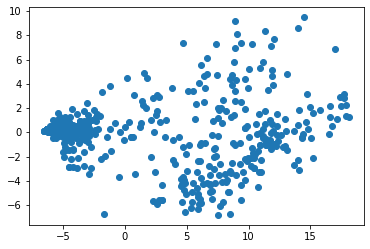

In [37]:
fig, ax = plt.subplots()
ax.scatter(df_2d[0], df_2d[1])

plt.show()

Doing 2 clusters as even without knowing the labels necessarily, we would have to think the main goal is going to be benign or malignant i.e. two classification possibilities

In [107]:
kmeans = KMeans(n_clusters=2)
y_pred  = kmeans.fit_predict(df_copy)
y_pred

array([0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1,

Appending the predicted labels back to the dataset, let's take a peek

In [89]:
full_copy = df_copy.copy()
full_copy["Cluster Label"] = y_pred
full_copy = full_copy.sort_values(by=['Cluster Label'])

full_copy.head()

,Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Cluster Label
63,6,3,4,1,5,2.0,3,9,1,0
234,3,3,2,1,3,1.0,3,6,1,0
43,5,6,5,6,10,1.0,3,1,1,0
288,6,1,3,1,4,5.0,5,10,1,0
148,3,1,1,3,8,1.0,5,8,1,0


Again, I would be hard pressed to say we should use more than 2 clusters, but let's just take a look.

In [102]:
range_n_clusters = list (range(2,20))

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters)
    preds = clusterer.fit_predict(df_copy)
    centers = clusterer.cluster_centers_

    score = silhouette_score(df_copy, preds)
    print("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))

For n_clusters = 2, silhouette score is 0.5967981179111456)
For n_clusters = 3, silhouette score is 0.5256774849851862)
For n_clusters = 4, silhouette score is 0.5348319035829242)
For n_clusters = 5, silhouette score is 0.2609547397060147)
For n_clusters = 6, silhouette score is 0.2541782135016473)
For n_clusters = 7, silhouette score is 0.2508030368809195)
For n_clusters = 8, silhouette score is 0.2519464184857933)
For n_clusters = 9, silhouette score is 0.2545421310146639)
For n_clusters = 10, silhouette score is 0.2569395827474422)
For n_clusters = 11, silhouette score is 0.2545487055943905)
For n_clusters = 12, silhouette score is 0.2564671187938571)
For n_clusters = 13, silhouette score is 0.25571274347665546)
For n_clusters = 14, silhouette score is 0.25342329295022187)
For n_clusters = 15, silhouette score is 0.2595748593655223)
For n_clusters = 16, silhouette score is 0.2007858888676558)
For n_clusters = 17, silhouette score is 0.2689281311798134)
For n_clusters = 18, silhouett

Number of clusters dropping after 2 would make sense as we have 2 labels in our original dataframe/two possibilties

In [114]:
subset_df = full_copy[["Uniformity of Cell Size", "Bare Nuclei", "Cluster Label"]]
                  
subset_df.head()                

,Uniformity of Cell Size,Bare Nuclei,Cluster Label
0,1,1.0,0
443,1,2.0,0
444,1,1.0,0
445,1,1.0,0
446,1,1.0,0


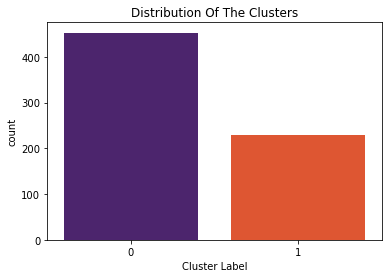

In [115]:
#Plotting countplot of clusters
pal = ["#4D1979", "#FA4616", "#C1D82F", "#00B2A9"]
pl = sns.countplot(x=full_copy["Cluster Label"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

In [116]:
full_copy['Cluster Label'].value_counts()

0    453
1    230
Name: Cluster Label, dtype: int64

Wow! It does seem that the clusters identified the benign/malignant very well. For reference in the original set minus some n/a deletions we had:
2    444 (benign)
4    239 (malignant)




Using the unsupervised learning we still see the data seems to lead to the two clusters we would expect, and reinforces the idea that these features are able to help us correctly identify whether a tumor is benign or malignant